# Capstone Project: Purchasing a new House in the Bay Area

### Importing Necessary Libraries 

In [9]:
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
import re
from geopy.geocoders import Nominatim
import pprint
import folium
from folium.features import DivIcon
from folium import IFrame
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize

# Importing uszipcode Library
from uszipcode import SearchEngine
from uszipcode import Zipcode

# Four Square credentials
client_id = 'VRV1LE5CKTH0WFGA32XUYB4DA0MFJZI4JCH12VXTAMI34IKO'
client_secret = '3UM0PQ3OKHHUAFYIP4AKFHJEH32Q4A54HJXRSHGM3RVCK2NW'
version = '20180605'

# OpenCage Geocoding API key
my_api_key = '04a70aca73754e30877b9cd311f378b5'

# Zillow ZWSID
zwsid = 'X1-ZWz176oqqqd6ob_6a5jo'

### Shortlisting the cities based on population
In order to decide what cities population to explore, I web scraped a cities list from the Santa Clara County (found on Wikipedia). Thus, this project will limit itself to exploring the four cities in the Santa Clara County with the largest population: San Jose, Sunnyvale, Santa Clara, and Mountain View. 

In [10]:
# Scraping the near-by cities list from wikipedia
sc_nearby = "https://en.wikipedia.org/wiki/Santa_Clara_County,_California"
response = requests.get(sc_nearby)

# Parsing the results with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find_all("table", class_= "wikitable")
population_table = table[9]
pop_def = population_table.find_all("td")

city_list = []
population_list = []

for i in range(0, 50, 4):
    city_list.append(pop_def[i + 1].text.strip())
    population_list.append(pop_def[i + 3].contents[0])

city_df = pd.DataFrame(columns = ["City Name", "Population"])
city_df["City Name"] = city_list 
city_df["Population"] = population_list
city_df

,City Name,Population
0,† San Jose,"945,942\n"
1,Sunnyvale,"140,081\n"
2,Santa Clara,"116,468\n"
3,Mountain View,"74,066\n"
4,Milpitas,"66,790\n"
5,Palo Alto,"64,403\n"
6,Cupertino,"58,302\n"
7,Gilroy,"48,821\n"
8,Campbell,"39,349\n"
9,Morgan Hill,"37,882\n"


### Finding Longitude and Lattitude
Using OpenCage Geocoding APIs, I found the latitude and longitude coordinates of the 4 cities. This information will be used later. 

In [11]:
cities = ['San Jose', 'Sunnyvale', 'Santa Clara', 'Mountain View']
lat_list = []
long_list = []
top_city_df = pd.DataFrame(columns = ["City Name", "Population", "Latitude", "Longitude"])

for city in cities:
    query = city + ", CA, United States of America"
    uri = "https://api.opencagedata.com/geocode/v1/json?q={}&key={}".format(query, my_api_key)
    response = requests.get(uri).json()
    lat_list.append(response['results'][0]['geometry']['lat'])
    long_list.append(response['results'][0]['geometry']['lng'])
    
top_city_df["City Name"] = cities
top_city_df["Latitude"] = lat_list
top_city_df["Population"] = city_df["Population"]
top_city_df["Longitude"] = long_list
    
top_city_df

,City Name,Population,Latitude,Longitude
0,San Jose,"945,942\n",37.336191,-121.890583
1,Sunnyvale,"140,081\n",37.368830,-122.036350
2,Santa Clara,"116,468\n",37.233325,-121.684635
3,Mountain View,"74,066\n",37.389389,-122.083210


### Exploring the 4 cities 
There are many factors to consider when purchasing a house. Thus, I will explore different aspects that could influence this decision making process:
* Food [Grocery shops, restaurants, coffee shops]
* Education [elementary schools, middle schools, high schools, colleges]
* Health [Hospital, Pharmacies, Clinics, Dentist]
* Entertainment [Movie Theaters, Bars]
* Average prices of the house 

By using FourSquare, I am able to use an API that will retrieve a list of venues matching each category: https://api.foursquare.com/v2/venues/search?categoryId={}. In this project, I pull from the category ids from the high-level grouping and make a list to make a collection of this data. 

In [12]:
# Creating a function that will construct a basic GET Request URL for each venue categories 
def requestPayload(lat, long, category):
    limit = 500      # Number of locations to return
    radius = 8050    # Approximately 5 mile radius
    url = "https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&limit={}&radius={}&ll={},{}".format(category, client_id, client_secret, version, limit, radius, lat, long)
    return url

### **1) Food Venues**

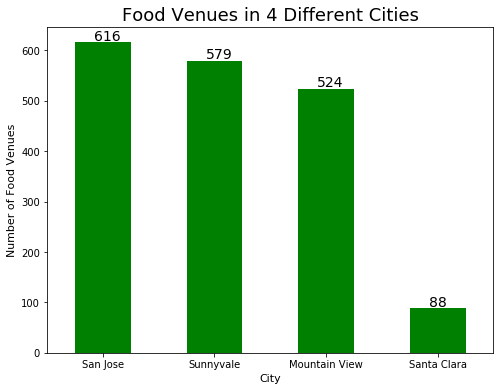

In [13]:
# List holding the category IDs of all the venues related to food (e.g. 'Food', 'Food and Drink Shop', etc.). 
food_list = ["4bf58dd8d48988d16e941735", "4d4b7105d754a06374d81259", "4bf58dd8d48988d14e941735", "4bf58dd8d48988d142941735", 
             "4bf58dd8d48988d111941735", "4bf58dd8d48988d149941735", "4bf58dd8d48988d1df931735",
             "4bf58dd8d48988d113941735", "4eb1d5724b900d56c88a45fe", "4bf58dd8d48988d1d1941735",  
             "4bf58dd8d48988d143941735", "4bf58dd8d48988d16d941735", "4bf58dd8d48988d1e0931735", 
             "4bf58dd8d48988d147941735"]

# Empty DF holding results 
food_df = pd.DataFrame(columns=["City Name", "Venue", "Latitude", "Longitude"])
venues_list = []
lat_list = []
long_list = []
city_list = []

for city in range(4):
    for category in food_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            lat_list.append(response['response']['venues'][i]['location']['lat'])
            long_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "City Name"])
            
food_df["City Name"] = city_list
food_df["Venue"] = venues_list
food_df["Latitude"] = lat_list
food_df["Longitude"] = long_list

food_df

# Plotting the food venues in four cities for comparison
ax = food_df['City Name'].value_counts().plot(kind = 'bar', figsize = (8,6), fontsize = 10, color = 'green')
ax.set_xlabel("City", fontsize = 11)
plt.xticks(rotation = 0)
ax.set_ylabel("Number of Food Venues", fontsize = 11)
plt.title("Food Venues in 4 Different Cities", fontsize = 18)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+4.0, str(i.get_height()), fontsize=14)

### **2) Education Venues**

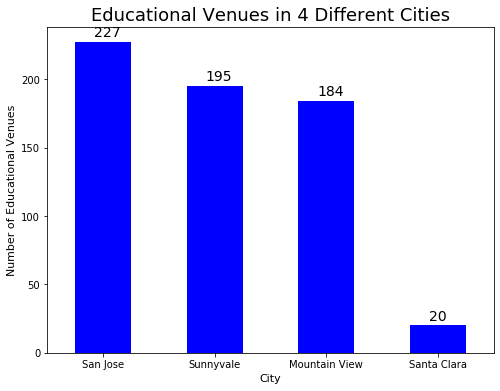

In [14]:
# List holding the category IDs of all the venues related to education (e.g. 'High Schools', 'College', etc.).
education_list = ["4d4b7105d754a06372d81259", "4f4533804b9074f6e4fb0105", "4f4533814b9074f6e4fb0106", 
                  "4bf58dd8d48988d13d941735", "52e81612bcbc57f1066b7a45"]

# Empty DF holding results 
education_df = pd.DataFrame(columns=["City Name", "Venue", "Latitude", "Longitude"])
venues_list = []
lat_list = []
long_list = []
city_list = []

for city in range(4):
    for category in education_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            lat_list.append(response['response']['venues'][i]['location']['lat'])
            long_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "City Name"])
            
education_df["City Name"] = city_list
education_df["Venue"] = venues_list
education_df["Latitude"] = lat_list
education_df["Longitude"] = long_list

education_df

# Plotting the food venues in four cities for comparison
ax = education_df['City Name'].value_counts().plot(kind = 'bar', figsize = (8,6), fontsize = 10, color = 'blue')
ax.set_xlabel("City", fontsize = 11)
plt.xticks(rotation = 0)
ax.set_ylabel("Number of Educational Venues", fontsize = 11)
plt.title("Educational Venues in 4 Different Cities", fontsize = 18)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+4.0, str(i.get_height()), fontsize=14)

### **3. Health Venues** 

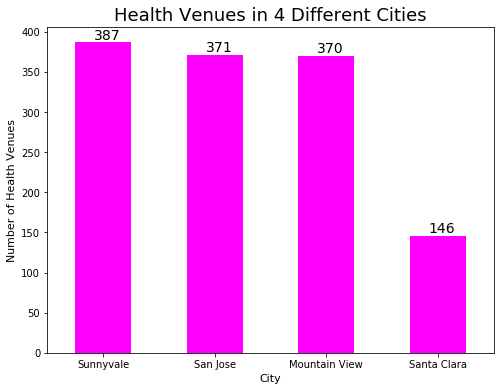

In [15]:
# List holding the category IDs of all the venues related to education (e.g. 'Hospitals', etc.).
health_list = ["4d4b7105d754a06377d81259", "4f4528bc4b90abdf24c9de85", "4bf58dd8d48988d104941735", 
               "56aa371be4b08b9a8d573526", "54541900498ea6ccd0202697", "4bf58dd8d48988d10f951735",
              "4bf58dd8d48988d194941735", "4bf58dd8d48988d177941735", "5744ccdfe4b0c0459246b4af", 
               "4bf58dd8d48988d177941735"]
# Empty DF holding results 
health_df = pd.DataFrame(columns=["City Name", "Venue", "Latitude", "Longitude"])
venues_list = []
lat_list = []
long_list = []
city_list = []

for city in range(4):
    for category in health_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            lat_list.append(response['response']['venues'][i]['location']['lat'])
            long_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "City Name"])
            
health_df["City Name"] = city_list
health_df["Venue"] = venues_list
health_df["Latitude"] = lat_list
health_df["Longitude"] = long_list

health_df

# Plotting the food venues in four cities for comparison
ax = health_df['City Name'].value_counts().plot(kind = 'bar', figsize = (8,6), fontsize = 10, color = 'magenta')
ax.set_xlabel("City", fontsize = 11)
plt.xticks(rotation = 0)
ax.set_ylabel("Number of Health Venues", fontsize = 11)
plt.title("Health Venues in 4 Different Cities", fontsize = 18)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+4.0, str(i.get_height()), fontsize=14)

### **4. Entertainment Venues**

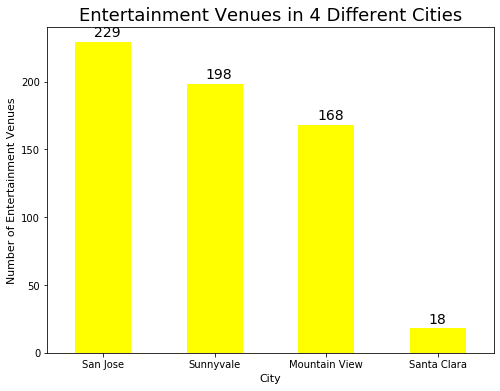

In [16]:
# List holding the category IDs of all the venues related to entertainment (e.g. 'Hospitals', etc.).
entertainment_list = ["4bf58dd8d48988d1e4931735", "4bf58dd8d48988d17f941735", "4bf58dd8d48988d181941735", 
                      "4bf58dd8d48988d184941735", "4d4b7105d754a06376d81259", "4bf58dd8d48988d11f941735"]

# Empty DF holding results 
entertainment_df = pd.DataFrame(columns=["City Name", "Venue", "Latitude", "Longitude"])
venues_list = []
lat_list = []
long_list = []
city_list = []

for city in range(4):
    for category in entertainment_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            lat_list.append(response['response']['venues'][i]['location']['lat'])
            long_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "City Name"])
            
entertainment_df["City Name"] = city_list
entertainment_df["Venue"] = venues_list
entertainment_df["Latitude"] = lat_list
entertainment_df["Longitude"] = long_list

entertainment_df

# Plotting the food venues in four cities for comparison
ax = entertainment_df['City Name'].value_counts().plot(kind = 'bar', figsize = (8,6), fontsize = 10, color = 'yellow')
ax.set_xlabel("City", fontsize = 11)
plt.xticks(rotation = 0)
ax.set_ylabel("Number of Entertainment Venues", fontsize = 11)
plt.title("Entertainment Venues in 4 Different Cities", fontsize = 18)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+4.0, str(i.get_height()), fontsize=14)

### **5. Average House Price**
We can get the median pricing of a house in a certain area using this link from Zillow: https://www.zillow.com/{city}-{state}/home-values/. We will be using this link along with some parsing to get the median prices of the house and other details.  crafting the request payload to get the house's median price, 1-year change, and 1-year forecast

In [18]:
# Creating the request payload 
req_headers = { 'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
               'accept-encoding': 'gzip, deflate, br',
               'accept-language': 'en-US,en;q=0.8',
               'upgrade-insecure-requests': '1',
               'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
        }

median_values = []
last_change = []
forecast = []
cities = ["sunnyvale", "san-jose", "mountain-view", "santa-clara"]

for city in cities:
    url = "https://www.zillow.com/{}-tx/home-values/".format(city)
    response = requests.get(url, headers = req_headers)
    soup = BeautifulSoup(response.content, "html.parser")
    median = soup.find_all("h2")
    median_values.append(median[0].text)
    
    change_list = soup.find_all("ul", class_= "zsg-g")
    list_item = change_list[0].find_all("li")
    last_change.append(list_item[0].text)    
    forecast.append(list_item[1].text.strip())
    
# Creating df for the Zillow data
home_value_df = pd.DataFrame(columns = ["City", "Last Year Value", "Current Median Value", "Next Year Forecast"])
home_value_df["City"] = cities
home_value_df["Last Year Value"] = last_change
home_value_df["Current Median Value"] = median_values
home_value_df["Next Year Forecast"] = forecast

#home_value_df
# Cleaning dataframe by creating a regex pattern and parsing through the columns 
new_ly_values = []
new_fc_values = []

percentage_regex = re.compile(r'\d+.\d+%')

for values in home_value_df["Last Year Value"]:
    sliced_value = percentage_regex.search(values)
    new_ly_values.append(sliced_value.group())

for values in home_value_df["Next Year Forecast"]:
    sliced_value = percentage_regex.search(values)
    new_fc_values.append(sliced_value.group())

home_value_df["Last Year Value"] = new_ly_values
home_value_df["Next Year Forecast"] = new_fc_values
home_value_df["Current Median Value"] = home_value_df["Current Median Value"].str.replace("$", "")
home_value_df["Current Median Value"] = home_value_df["Current Median Value"].str.replace(",", "")

# Eliminating percentage value by calculating the real values for the next year forecast 
home_value_df["Last Year Value"] = home_value_df["Last Year Value"].str.replace("%","")
home_value_df["Next Year Forecast"] = home_value_df["Next Year Forecast"].str.replace("%","")

for i in range(len(home_value_df)):
    last_percent = float(home_value_df.loc[i, "Last Year Value"])
    forecast = float(home_value_df.loc[i, "Next Year Forecast"])
    median_value = float(home_value_df.loc[i, "Current Median Value"])
    
    last = float(last_percent/100)
    fore = float(forecast/100)
    home_value_df.loc[i, "Last Year Value"] = (1 - last) * median_value
    home_value_df.loc[i, "Next Year Forecast"] = (1 + fore) * median_value

home_value_df

,City,Last Year Value,Current Median Value,Next Year Forecast
0,sunnyvale,412049,420030,433051
1,san-jose,127926,134517,142723
2,mountain-view,92733.1,99499,100991
3,santa-clara,330191,337274,350428


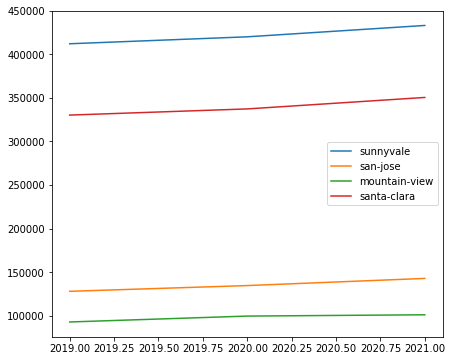

In [19]:
plt_df = pd.DataFrame({
   'sunnyvale': [412049,420030,433051],
   'san-jose': [127926,134517,142723],
    'mountain-view': [92733.1,99499,100991],
    'santa-clara': [330191,337274,350428]
    
   }, index = [2019, 2020, 2021])

plt_lines = plt_df.plot.line(figsize = (7,6))

## Exploring San Jose

In [20]:
# Creating df based on previously collected venue info
sj_df = pd.concat([
    health_df[health_df["City Name"] == "San Jose"],
    food_df[food_df["City Name"] == "San Jose"],
    education_df[education_df["City Name"] == "San Jose"],
    entertainment_df[entertainment_df["City Name"] == "San Jose"]], ignore_index = True)

print(sj_df.shape)

# Trying to plot venues into a map with markers
sj_map = folium.Map(location = [37.336191, -121.890583], zoom_start = 10)

for lat, lng, venue in zip(sj_df['Latitude'], sj_df['Longitude'], sj_df['Venue']):
    label = "".format(venue)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color='#3186cc',
        fill_opacity = 0.3,
        parse_html = False).add_to(sj_map)

sj_map

(1443, 4)


In [21]:
# Retrieve zip codes 
sj_zip = "http://www.city-data.com/zipmaps/San-Jose-California.html"
response = requests.get(sj_zip)
ziplist = []

soup = BeautifulSoup(response.text, "html.parser")
table = soup.find_all('div', class_ = "zip data-block")
for t in table:
    ziplist.append(t["id"])

ziplist[0:10]

# Making the search engine
search = SearchEngine(simple_zipcode = True)
results = []
for z in ziplist:
    zipcode = search.by_zipcode(z)
    data = zipcode.to_dict()
    results.append(data)
 
sj_zip_df = json_normalize(results)
sj_zip_df.head()

# now let us drop some unwanted & obvious columns to focus our analysis
sj_zip_df = sj_zip_df.drop(['bounds_east', 'bounds_north', 'bounds_south', 'area_code_list', 'common_city_list', 'population_density', 'bounds_west', 'major_city', 'post_office_city', 'state', 'timezone', 'zipcode_type'], 1)
sj_zip_df.head()

# cleaning the dataframe a bit to make it more readable and usable
sj_zip_df['county'] = sj_zip_df['county'].str.replace("County","")
zipcol = sj_zip_df['zipcode']
sj_zip_df.drop('zipcode', axis = 1,inplace = True)
sj_zip_df.insert(0, 'zipcode', zipcol)

sj_zip_df.head()

# one-hot encoding the county names
county_dummies = pd.get_dummies(sj_zip_df['county'], prefix = 'county')
sj_df = pd.concat([sj_zip_df, county_dummies], axis = 1)
sj_df = sj_df.drop('county', 1)
sj_df.head()

/Users/anaissarrazin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,zipcode,lat,lng,radius_in_miles,population,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,county_Santa Clara
0,94089,37.400,-122.000,2.000000,19245,5.99,0.01,7530,7270,168300,85769,1
1,95002,37.425,-121.976,0.170455,2077,11.97,2.31,614,579,411600,70114,1
2,95008,37.280,-121.940,2.000000,45260,6.39,0.09,19410,18513,658700,87204,1
3,95014,37.300,-122.070,5.000000,60717,26.93,0.13,22035,21122,1000001,127870,1
4,95032,37.210,-121.920,5.000000,25089,15.89,0.14,10568,10147,1000001,122163,1


### Clustering on San Jose data

In [22]:
# Set number of clusters
k = 4

# K-Means clustering
kmeans = KMeans(n_init = 400, n_clusters = k, random_state = 1).fit(sj_df)
kmeans.labels_

sj_df.insert(0, 'Cluster', kmeans.labels_)
sj_df.head()

,Cluster,zipcode,lat,lng,radius_in_miles,population,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,county_Santa Clara
0,3,94089,37.400,-122.000,2.000000,19245,5.99,0.01,7530,7270,168300,85769,1
1,0,95002,37.425,-121.976,0.170455,2077,11.97,2.31,614,579,411600,70114,1
2,2,95008,37.280,-121.940,2.000000,45260,6.39,0.09,19410,18513,658700,87204,1
3,1,95014,37.300,-122.070,5.000000,60717,26.93,0.13,22035,21122,1000001,127870,1
4,1,95032,37.210,-121.920,5.000000,25089,15.89,0.14,10568,10147,1000001,122163,1


In [23]:
# Cluster 1
cluster_one = sj_df[sj_df.Cluster == 0]
cluster_one.sort_values("median_home_value", axis = 0, ascending = True, inplace = True) 
cluster_one

/Users/anaissarrazin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Cluster,zipcode,lat,lng,radius_in_miles,population,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,county_Santa Clara
10,0,95110,37.340,-121.910,3.000000,18730,4.67,0.00,6339,5723,386200,63184,1
1,0,95002,37.425,-121.976,0.170455,2077,11.97,2.31,614,579,411600,70114,1
25,0,95127,37.390,-121.780,5.000000,61325,13.01,0.00,16416,15741,419600,68379,1
12,0,95112,37.340,-121.880,4.000000,55927,7.09,0.00,20763,19525,421000,48370,1
19,0,95121,37.300,-121.810,2.000000,37469,4.43,0.00,9625,9352,443600,82001,1
31,0,95133,37.370,-121.860,2.000000,25401,3.18,0.00,7651,7365,447700,66705,1
17,0,95119,37.230,-121.790,2.000000,9970,2.83,0.00,3200,3094,490500,109745,1
21,0,95123,37.240,-121.840,3.000000,62228,8.32,0.00,22035,21123,502200,87180,1
34,0,95136,37.270,-121.840,2.000000,42989,4.73,0.00,15448,15002,512200,86547,1
5,0,95035,37.440,-121.840,6.000000,66943,23.24,0.06,19874,19241,513400,95437,1


In [24]:
# Cluster 2
cluster_two = sj_df[sj_df.Cluster == 1]
cluster_two.sort_values("median_home_value", axis = 0, ascending = True, inplace = True) 
cluster_two

/Users/anaissarrazin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Cluster,zipcode,lat,lng,radius_in_miles,population,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,county_Santa Clara
27,1,95129,37.31,-122.00,2.0,38720,4.51,0.00,14517,14011,862100,104705,1
18,1,95120,37.17,-121.84,6.0,37457,39.76,0.72,12785,12555,922600,150675,1
3,1,95014,37.30,-122.07,5.0,60717,26.93,0.13,22035,21122,1000001,127870,1
4,1,95032,37.21,-121.92,5.0,25089,15.89,0.14,10568,10147,1000001,122163,1
9,1,95070,37.27,-122.05,4.0,30617,25.49,0.02,11379,10977,1000001,158655,1
37,1,95140,37.40,-121.70,9.0,191,123.73,0.08,130,81,1000001,163229,1


In [25]:
# Cluster 3
cluster_three = sj_df[sj_df.Cluster == 2]
cluster_three.sort_values("median_home_value", axis = 0, ascending = True, inplace = True) 
cluster_three

/Users/anaissarrazin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Cluster,zipcode,lat,lng,radius_in_miles,population,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,county_Santa Clara
30,2,95132,37.430,-121.800,6.000000,40299,50.97,2.03,11899,11613,568000,95198,1
26,2,95128,37.320,-121.930,2.000000,34836,3.90,0.00,14295,13446,572200,66533,1
24,2,95126,37.320,-121.910,2.000000,31049,3.28,0.00,13815,12903,577900,70351,1
38,2,95148,37.330,-121.770,4.000000,45528,9.42,0.10,11747,11404,582900,105438,1
7,2,95050,37.350,-121.950,2.000000,35923,5.28,0.00,14855,14078,601400,67630,1
16,2,95118,37.260,-121.890,2.000000,31932,4.15,0.00,11544,11261,603400,89265,1
8,2,95054,37.400,-121.960,2.000000,23364,6.26,0.00,8891,8447,605900,110099,1
6,2,95037,37.100,-121.700,13.000000,45579,243.32,2.44,15626,14904,606900,95047,1
15,2,95117,37.310,-121.970,1.000000,30067,2.57,0.00,11263,10863,623800,63465,1
13,2,95113,37.334,-121.891,0.568182,893,0.34,0.00,992,575,630700,34345,1


In [26]:
# Cluster 4
cluster_four = sj_df[sj_df.Cluster == 3]
cluster_four.sort_values("median_home_value", axis = 0, ascending = True, inplace = True) 
cluster_four

/Users/anaissarrazin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Cluster,zipcode,lat,lng,radius_in_miles,population,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,county_Santa Clara
0,3,94089,37.40,-122.00,2.0,19245,5.99,0.01,7530,7270,168300,85769,1
32,3,95134,37.42,-121.97,4.0,15268,9.48,0.29,7068,6758,169500,113212,1
14,3,95116,37.35,-121.85,2.0,51496,3.58,0.00,13663,13081,320900,48805,1
20,3,95122,37.33,-121.84,2.0,56545,4.77,0.00,12702,12290,330000,56140,1
11,3,95111,37.28,-121.83,2.0,58466,5.39,0.01,15511,15035,334300,57120,1


Now, after sorting the median_home_value column in each clusters, we can clearly see that each cluster gave us a bucket range of the median home values. As a final step, we will plot these different clusters into SJ map that will be useful for the final user to see which areas have what kind of budgets to purchase a house.

In [27]:
# Creating budget df
cluster_one.insert(0, 'Budget', 'LOW')
cluster_two.insert(0, 'Budget', 'HIGH')
cluster_three.insert(0, 'Budget', 'MEDIUM')
cluster_four.insert(0, 'Budget', 'VERY LOW')

sj_budget = pd.concat([cluster_one, cluster_two, cluster_three, cluster_four], ignore_index = True)

sj_house = pd.DataFrame(columns = ['Budget', 'Zipcode', 'Latitude', 'Longitude'])
sj_house['Budget'] = sj_budget['Budget']
sj_house['Zipcode'] = sj_budget['zipcode']
sj_house['Latitude'] = sj_budget['lat']
sj_house['Longitude'] = sj_budget['lng']

sj_house

,Budget,Zipcode,Latitude,Longitude
0,LOW,95110,37.340,-121.910
1,LOW,95002,37.425,-121.976
2,LOW,95127,37.390,-121.780
3,LOW,95112,37.340,-121.880
4,LOW,95121,37.300,-121.810
5,LOW,95133,37.370,-121.860
6,LOW,95119,37.230,-121.790
7,LOW,95123,37.240,-121.840
8,LOW,95136,37.270,-121.840
9,LOW,95035,37.440,-121.840


In [30]:
# Map of San Jose 
sj_map = folium.Map(location = [37.336191, -121.890583], zoom_start = 10)

for lat, lng, zipcode, budget in zip(sj_house['Latitude'], sj_house['Longitude'], sj_house['Zipcode'], sj_house['Budget']):
    if budget == "VERY LOW":
        label = folium.Popup(str(zipcode + " " + budget), parse_html = True)
        folium.CircleMarker([lat, lng], radius = 5, popup = label, color='green',fill = True,fill_color = '#008000',fill_opacity = 2.0,parse_html = False).add_to(sj_map)
    
    elif budget == "LOW":
        label = folium.Popup(str(zipcode + " " + budget), parse_html = True)
        folium.CircleMarker([lat, lng], radius = 5, popup = label, color = 'blue',fill=True,fill_color = '#0000FF',fill_opacity = 2.0,parse_html = False).add_to(sj_map)
    
    elif budget == "MEDIUM":
        label = folium.Popup(str(zipcode + " " + budget), parse_html = True)
        folium.CircleMarker([lat, lng], radius = 5, popup = label, color = 'orange',fill = True,fill_color = '#FF8C00',fill_opacity = 2.0,parse_html = False).add_to(sj_map)
    
    elif budget == "HIGH":
        label = folium.Popup(str(zipcode + " " + budget), parse_html = True)
        folium.CircleMarker([lat, lng], radius = 5, popup = label, color = 'red',fill = True,fill_color = '#FF6347',fill_opacity = 2.0,parse_html = False).add_to(sj_map)

sj_map